In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}

fig_params = {"dpi": 100, "figsize": (7, 7)}

In [2]:
detector_config = {
    "number_of_devices": 15,
    "distance_between_devices": 0.7,
    "wave_number": 6.283185307179586
}

In [3]:
# Количество приемных устройств
K = 10

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (0.82 * (M + 1) * d * 2)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.01 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [4]:
s

0.04148000663680107

In [5]:
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND

def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND

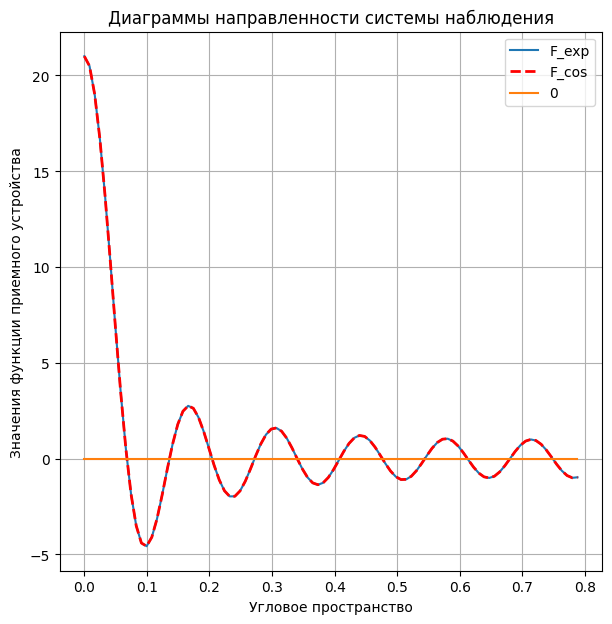

In [6]:
plt.figure(**fig_params)
plt.title("Диаграммы направленности системы наблюдения")
plt.plot(a1, np.real(Fexp(a1)), label = "F_exp")
plt.plot(a1, F(a1), linestyle = "--", 
         linewidth = 2, color= "r", label = "F_cos")
plt.plot(a1, np.zeros(a1.shape), label = "0")
plt.xlabel("Угловое пространство")
plt.ylabel("Значения функции приемного устройства")
plt.legend()
plt.grid()
plt.show()

In [7]:
def gauss_func(x, mean=0, var=1):
    return 1/(np.pi * 2 * np.sqrt(var)) * np.exp(-(x - mean)**2/(2 * var))

def signal_func(x, pos = [0.15, 0.45], var = 0.000005, magnitude = 600):
    pos = np.array(pos)
    var = np.array(var)
    signal = np.zeros_like(x)
    for idx, target in enumerate(pos):
        signal += gauss_func(x, target, var)
    return signal / np.max(signal) * magnitude

In [8]:
magnitude = 600
targets = [-0.03, 0.03]

Idel = lambda t: signal_func(t, pos = targets, magnitude = magnitude)

In [9]:
def integrand(t, alpha):
    return np.real(Fexp(t - alpha)) * Idel(t)

def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]

vec_U00 = np.vectorize(U00)

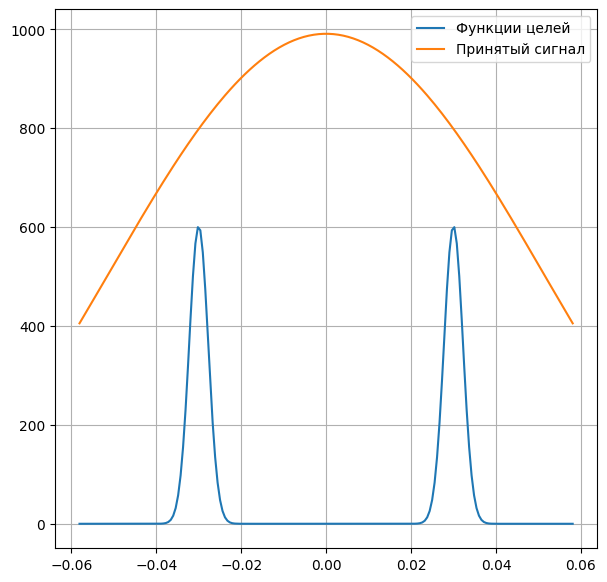

In [10]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

## Прогнозирование $C_n$

In [11]:
NP = 104
NPa = np.arange(0, NP + 1)

In [12]:
def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)

In [13]:
def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 

In [14]:
int_func = np.vectorize(integral_of_func)

In [15]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [16]:
C = Cn[:K+1]
CR = Cn[K+1:]

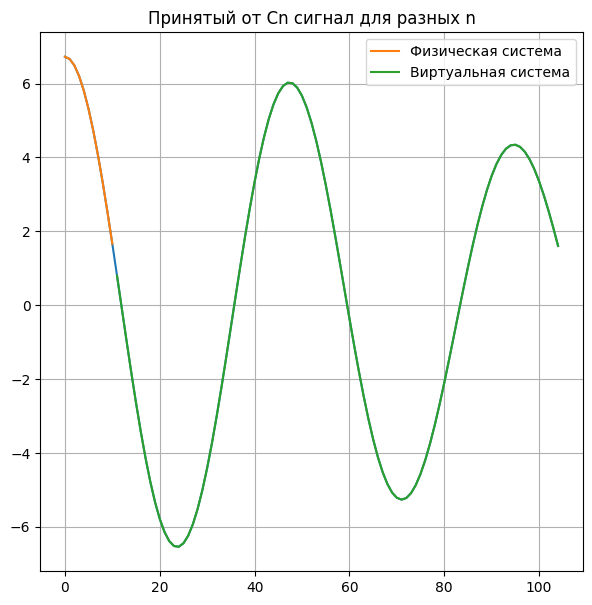

In [17]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

## Модель затухающих колебаний

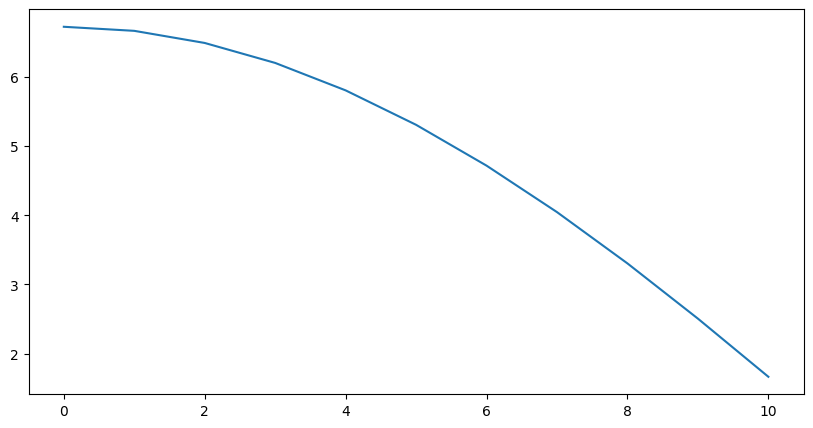

In [18]:
signal = lambda x, A, alpha, beta, epsilon: A * np.exp(alpha * x) * np.sin(beta * x + epsilon)
data = np.vstack([NPa[:K+1], C])

plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.show()

In [19]:
def grad_signal(x, data, A, alpha, beta, epsilon, clip = 255):
    grad = np.zeros(4)
    errors = signal(x, A, alpha, beta, epsilon) - data
    grad[0] = np.sum(errors * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[1] = np.sum(errors * A * x * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[2] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon) * x)
    grad[3] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon))
    return np.clip(grad / len(x), -clip, clip)

In [20]:
params_0 = np.array([data[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.001

num_of_data = data.shape[1]
batch_size = num_of_data // 1

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data[0, start_index:start_index + batch_size]
        y_batch = data[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

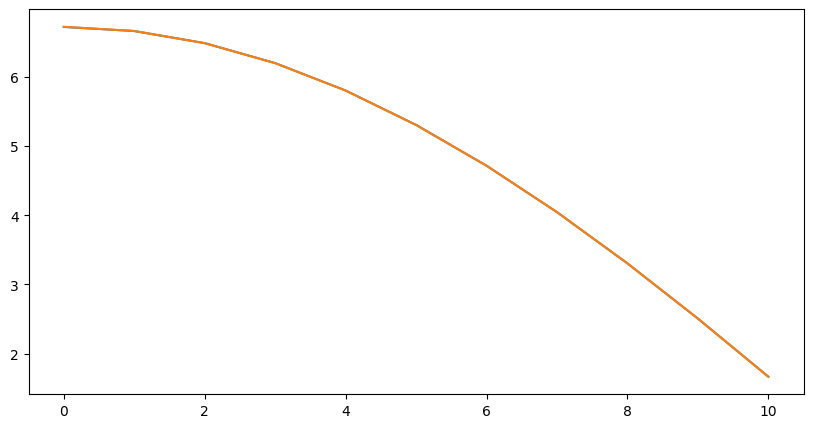

array([ 6.72889836e+00, -1.62730846e-05, -1.31829663e-01,  1.56811496e+00])

In [21]:
plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.plot(data[0], signal(data[0], params[0], params[1], params[2], params[3]))
plt.show()
params

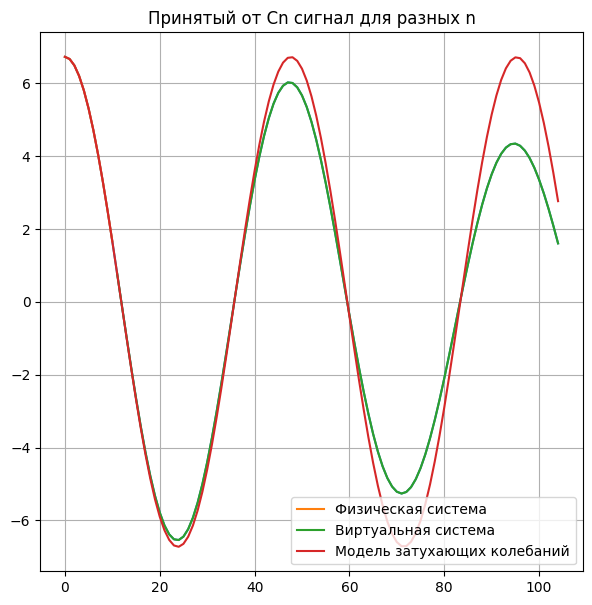

In [22]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, 
         signal(NPa, params[0], params[1], params[2], params[3]),
        label = "Модель затухающих колебаний")
plt.legend()
plt.grid()

## Авторегрессионная нейросеть 

In [23]:
# Формирование выборки
X_input = 5
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

In [24]:
from sklearn.neural_network import MLPRegressor

In [25]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18, 5), random_state=1, activation = "relu")

In [26]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(18, 5), random_state=1,
             solver='lbfgs')

In [27]:
regr.predict(C[-X_input:].reshape(1, -1))

array([0.90671285])

In [35]:
CRegr = C.copy()
for fut in np.arange(K+1, NP+1):
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

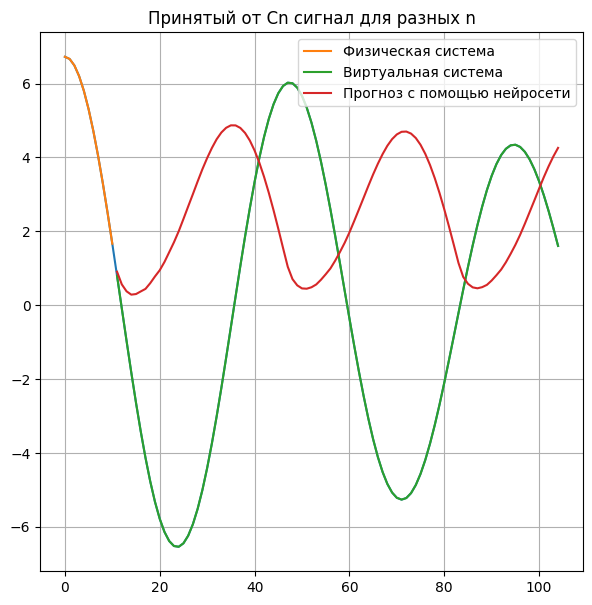

In [40]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa[K+1:], CRegr[K+1:], label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

In [37]:
# Взвешивение элементов системы наблюдения --------------------------------
def CnU(x, Cn):
    result = 0
    for n, c in enumerate(Cn[1:]):
        result += c * np.exp(-1j * (k * d * (n + 1) * (x))) + c * np.exp(1j * (k * d * (n + 1) * (x)))
    return result + Cn[0] * np.exp(1j * (k * d * (0) * (x)))

In [43]:
Result = CnU(a, CRegr)

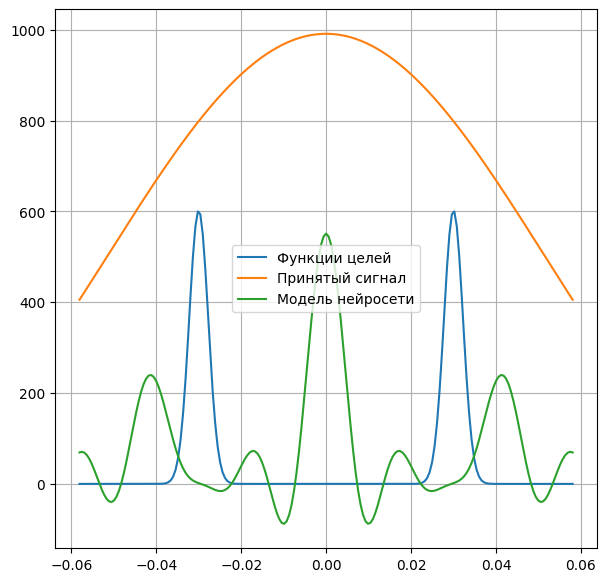

In [44]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result), label = "Модель нейросети")
plt.legend()
plt.grid()
plt.show()

## Интерполяция

In [45]:
# Данные для прогнозирования
interp_times = 10
x_interp = np.arange(0, K + 1/(interp_times+1), 1/interp_times)    # Сетка 
C_interp = np.interp(x_interp, np.arange(0, K+1), C)               # Линейная интерполяция

x_interp_future = np.arange(x_interp[-1] + 1/interp_times, NP + 1/(interp_times + 1), 1/interp_times)

In [46]:
X_input = 40
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C_interp, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

In [47]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18, 3), random_state=1, activation = "relu", max_iter = 1000)

In [48]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(18, 3), max_iter=1000,
             random_state=1, solver='lbfgs')

In [49]:
CRegr = C_interp.copy()
for fut in x_interp_future:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

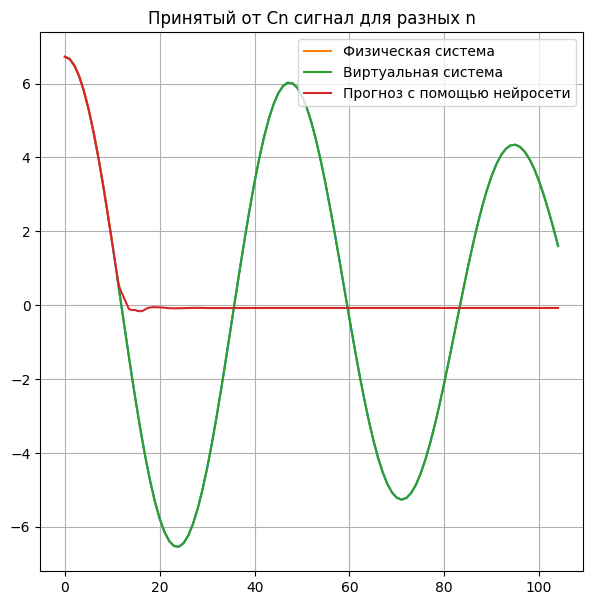

In [50]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(np.append(x_interp, x_interp_future), CRegr, label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

## Активное дообучение

In [53]:
X_input = len(C) - 1
Y_output = 1
window_size = (X_input + Y_output, )

regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(X_input, int(X_input / 2)), random_state=1, activation = "relu", max_iter = 1000)

CRegr = C.copy()
for fut in np.arange(K+1, NP+1):
    A_matrix = np.lib.stride_tricks.sliding_window_view(CRegr, window_shape = window_size)
    X_matrix = A_matrix[:, :X_input]
    Y_matrix = A_matrix[:, X_input:]
    regr.fit(X_matrix, Y_matrix[:, 0])
    x_interp = np.append(x_interp, np.array([x_interp[-1], 1/interp_times]))
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))


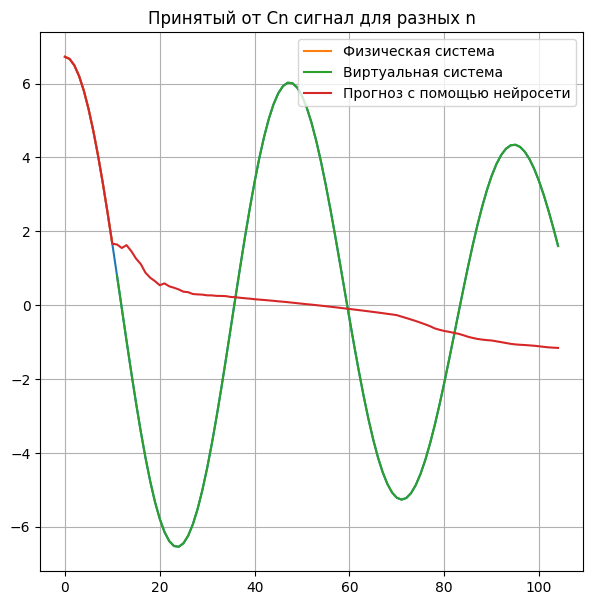

In [54]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, CRegr, label = "Прогноз с помощью нейросети")
plt.legend()
plt.grid()

## Обучение на симметричной области

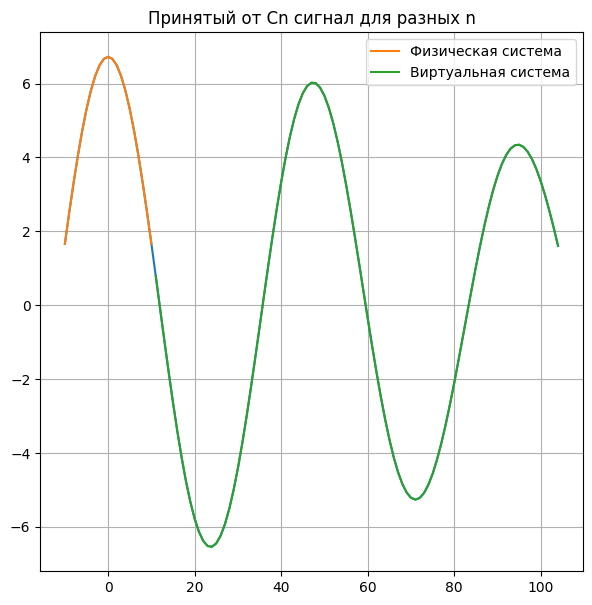

In [55]:
NP = 104
NPa = np.arange(0, NP + 1)
NPa_full = np.arange(-K, NP + 1)

given_field = np.arange(-K, K+1)

Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa_full)

C = Cn[:len(given_field)]
CR = Cn[len(given_field):]
NPa_CR = NPa_full[len(given_field):]

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa_full, Cn)
plt.plot(given_field, C, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.legend()
plt.grid()

In [56]:
X_input = K
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

regr = MLPRegressor(solver='sgd', alpha=1e-4,
                    hidden_layer_sizes=(14, 3), random_state=1, activation = "tanh", max_iter = 1000)

In [57]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(activation='tanh', hidden_layer_sizes=(14, 3), max_iter=1000,
             random_state=1, solver='sgd')

In [58]:
CRegr = C.copy()
for fut in NPa_CR:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

In [59]:
CRegr.shape

(115,)

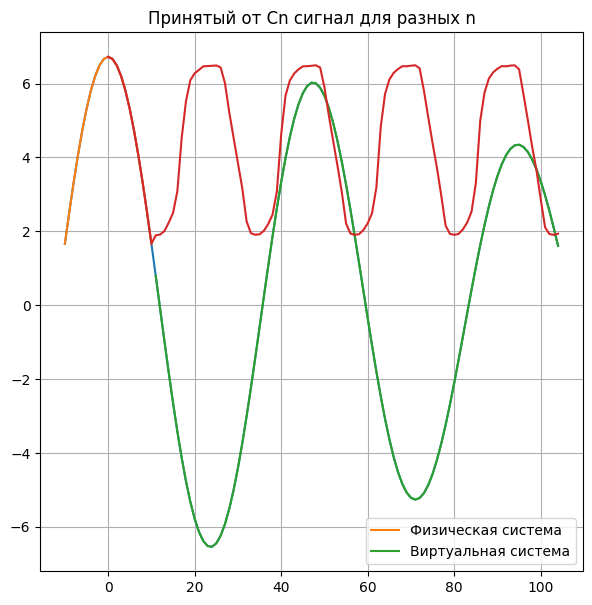

In [61]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa_full, Cn)
plt.plot(given_field, C, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.plot(NPa, CRegr[K:])
plt.legend()
plt.grid()

In [65]:
Res_sim_ff_fc = CnU(a, CRegr[K:])

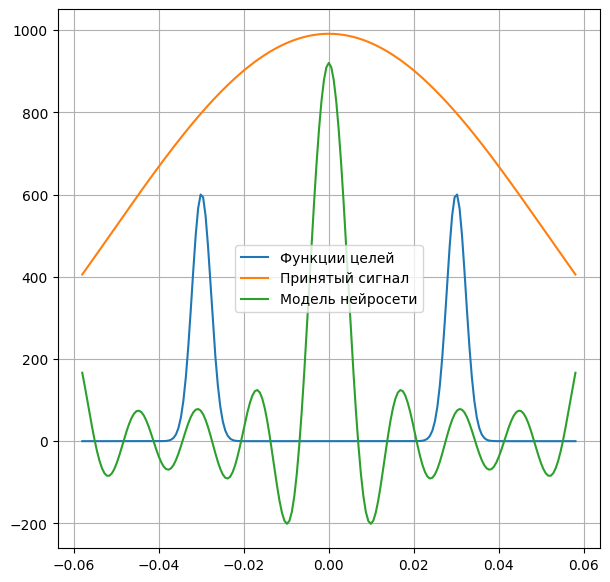

In [66]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Res_sim_ff_fc), label = "Модель нейросети")
plt.legend()
plt.grid()
plt.show()

## Интерполяция сплайнами

In [67]:
NP = 104
NPa = np.arange(0, NP + 1)
NPa_full = np.arange(-K, NP + 1)

given_field = np.arange(-K, K+1)

C = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = given_field)
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa_full)

In [68]:
# Интерполяция
from scipy.interpolate import CubicSpline

cs = CubicSpline(given_field, C)

In [69]:
# Данные для прогнозирования
interp_times = 5
x_interp = np.arange(-K, K + 1/(interp_times+1), 1/interp_times)    # Сетка 
C_interp = cs(x_interp)               # Линейная интерполяция

x_interp_future = np.arange(x_interp[-1] + 1/interp_times, NP + 1/(interp_times + 1), 1/interp_times)

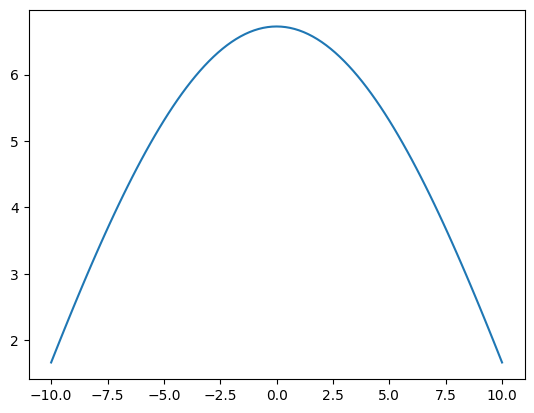

In [70]:
plt.plot(x_interp, C_interp)

In [105]:
X_input = K * 2
Y_output = 1
window_size = (X_input + Y_output, )
A_matrix = np.lib.stride_tricks.sliding_window_view(C_interp, window_shape = window_size)

X_matrix = A_matrix[:, :X_input]
Y_matrix = A_matrix[:, X_input:]

regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 9), random_state=1, activation = "tanh", max_iter = 1000)

In [106]:
regr.fit(X_matrix, Y_matrix[:, 0])

MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=(10, 9),
             max_iter=1000, random_state=1, solver='lbfgs')

In [107]:
X_matrix.shape

(81, 20)

In [108]:
CRegr = C_interp.copy()
for fut in x_interp_future:
    CRegr = np.append(CRegr, regr.predict(CRegr[-X_input:].reshape(1, -1)))

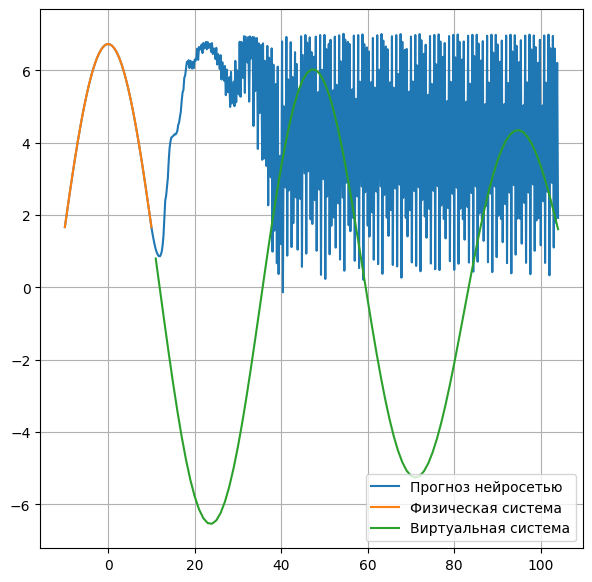

In [109]:
plt.figure(**fig_params)
plt.plot(np.append(x_interp, x_interp_future), CRegr, label = "Прогноз нейросетью")
plt.plot(x_interp, C_interp, label = "Физическая система")
plt.plot(NPa_CR, CR, label = "Виртуальная система")
plt.legend()
plt.grid()
plt.show()

In [110]:
data2 = np.vstack([x_interp[X_matrix.shape[0]//2:], C_interp[X_matrix.shape[0]//2:]])

In [111]:
data2.shape

(2, 61)

In [112]:
params_0 = np.array([data2[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.05

num_of_data = data2.shape[1]
batch_size = num_of_data // 2

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data2[0, start_index:start_index + batch_size]
        y_batch = data2[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

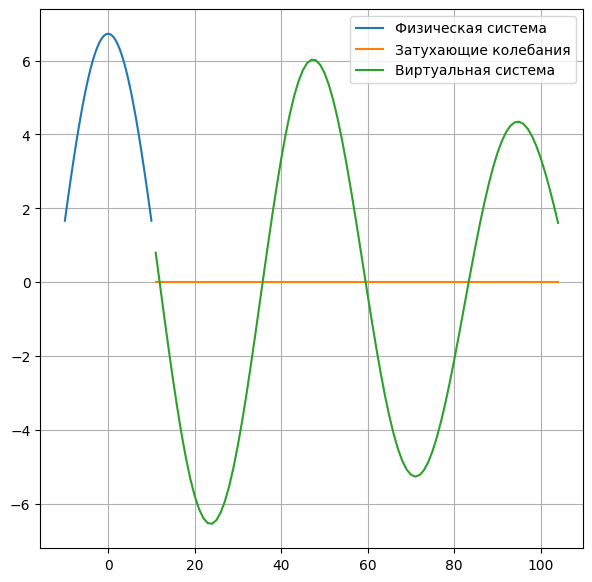

In [113]:
plt.figure(**fig_params)
#plt.plot(np.append(x_interp, x_interp_future), CRegr, label = "Прогноз нейросетью")
plt.plot(x_interp, C_interp, label = "Физическая система")
plt.plot(NPa_CR, signal(NPa_CR,params_0[0],
                        params_0[1],
                        params_0[2],
                        params_0[3]) , label = "Затухающие колебания")
plt.plot(NPa_CR, CR , label = "Виртуальная система")
plt.legend()
plt.grid()
plt.show()